# Linear Random Forest

In [2]:
from sklearn.linear_model import LinearRegression, Ridge
from lineartree import LinearTreeRegressor
from sklearn.metrics import root_mean_squared_error, mean_absolute_percentage_error
import pandas as pd
from joblib import dump
import matplotlib.pyplot as plt
import numpy as np
from sklearn.preprocessing import StandardScaler
import time

In [2]:
import sys
sys.path.append('F:\\Users\\Manuel García Plaza\\Desktop\\TFG\\')

In [3]:
from notebooks.utils.regression_metrics import regression
from notebooks.utils.lrf import LinearRandomForestRegressor

In [5]:
train =  pd.read_parquet('../../../data/model_input/train_sets/electricity_transformer.parquet')
validation =  pd.read_parquet('../../../data/model_input/validation_sets/electricity_transformer.parquet')

In [6]:
y_train = train.OT_next
X_train = train.drop(columns=['date', 'OT_next'])

In [7]:
y_validation = validation.OT_next
X_validation = validation.drop(columns=['date', 'OT_next'])

In [7]:
scaler = StandardScaler().fit(X_train)

In [8]:
X_train_scaled = scaler.transform(X_train)
X_validation_scaled = scaler.transform(X_validation)

In [22]:
n_estimators = [2, 3, 5, 7, 10, 15, 20, 25, 30, 35, 40]

In [23]:
max_depth = [1, 2, 3]
base_mod = [LinearRegression(), Ridge()]

In [24]:
base_est = []
for i in max_depth:
    for mod in base_mod:
        base_est.append(LinearTreeRegressor(base_estimator=mod, max_depth=i))

In [25]:
models_list = []
names_list = []
for n in n_estimators:
    for estim in base_est:
        models_list.append(LinearRandomForestRegressor(n_features=X_train.shape[1], est=estim, n_est=n))
        if isinstance(estim.base_estimator, LinearRegression):
            names_list.append(f'LRF_{n}_{estim.max_depth}')
        else:
            names_list.append(f'LRF_{n}_{estim.max_depth}_l2')

In [50]:
metrics = regression(models_list, names_list, '../../../data/model_output/metrics/electricity_transformer/lrf.csv', X_train_scaled, y_train, X_validation_scaled, y_validation)
metrics

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LRF_2_1,12.472734,0.748703,0.439765,-41.263092
LRF_2_1_l2,11.230134,1.222980,0.740911,-39.417578
LRF_2_2,14.384900,1.426324,1.206206,-15.432572
LRF_2_2_l2,14.531684,1.001547,0.760705,-24.046991
LRF_2_3,14.822251,1.030666,0.623783,-39.477678
...,...,...,...,...
LRF_40_1_l2,235.993530,1.217167,0.774050,-36.405629
LRF_40_2,323.640270,0.932497,0.619073,-33.611284
LRF_40_2_l2,283.766204,0.954100,0.620327,-34.983048
LRF_40_3,346.463305,0.917050,0.596874,-34.913725


In [51]:
metrics.sort_values(by='Validation_RMSE')

,Run_Time,Train_RMSE,Validation_RMSE,delta%
LRF_3_2,18.548520,0.553281,0.356933,-35.488015
LRF_2_1,12.472734,0.748703,0.439765,-41.263092
LRF_10_1,56.597592,0.872963,0.543497,-37.741065
LRF_5_1,27.470497,0.934415,0.545703,-41.599529
LRF_7_3_l2,45.175753,0.895269,0.553001,-38.230671
...,...,...,...,...
LRF_2_3_l2,11.455535,1.382172,0.831282,-39.856834
LRF_5_1_l2,25.472235,1.117064,0.837078,-25.064487
LRF_7_2,45.357913,1.337263,0.904633,-32.351884
LRF_20_2,156.295635,1.233599,0.920619,-25.371333


Let's retrain **LRF_3_2**

In [8]:
test =  pd.read_parquet('../../../data/model_input/test_sets/electricity_transformer.parquet')

In [9]:
y_test = test.OT_next
X_test = test.drop(columns=['date', 'OT_next'])

In [10]:
retrain = pd.concat([train, validation])

In [11]:
y_retrain = retrain.OT_next
X_retrain = retrain.drop(columns=['date', 'OT_next'])

In [12]:
scaler_retrain = StandardScaler().fit(X_retrain)

In [13]:
X_retrain_scaled = scaler_retrain.transform(X_retrain)
X_test_scaled = scaler_retrain.transform(X_test)

In [ ]:
time1 = time.time()
model = LinearRandomForestRegressor(n_features=X_retrain.shape[1], est=LinearTreeRegressor(base_estimator=LinearRegression(), max_depth=2), n_est=3).fit(X_retrain_scaled, y_retrain)
time2 = time.time() - time1

In [105]:
test_pred = model.predict(X_test_scaled)
rmse = root_mean_squared_error(y_test, test_pred)
print('Test RMSE:', round(rmse, 4))

Test RMSE: 0.5238


In [114]:
train_pred = model.predict(X_retrain_scaled)
rmse_train = root_mean_squared_error(y_retrain, train_pred)

In [116]:
with open('../../../data/model_output/metrics/electricity_transformer/final_metrics.txt', 'a') as f:
     f.write(f'\nLRF; {time2}; {rmse_train}; {rmse}')

In [117]:
dump(model, '../../../data/model_output/models/electricity_transformer/best_lrf.joblib')

['../../../data/model_output/models/electricity_transformer/best_lrf.joblib']

C:\Users\MANUEL~2\AppData\Local\Temp/ipykernel_1488/591326651.py:7: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "k--" (-> color='k'). The keyword argument will take precedence.
  plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],


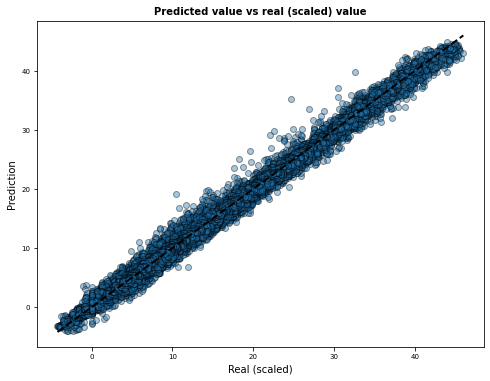

In [118]:
prediction_retrain = model.predict(X_retrain_scaled)
error_retrain   = prediction_retrain - y_retrain

plt.figure(figsize=(8, 6))

plt.scatter(y_retrain, prediction_retrain, edgecolors=(0, 0, 0), alpha = 0.4)
plt.plot([y_retrain.min(), y_retrain.max()], [y_retrain.min(), y_retrain.max()],
                'k--', color = 'black', lw=2)
plt.title('Predicted value vs real (scaled) value', fontsize = 10, fontweight = "bold")
plt.xlabel('Real (scaled)')
plt.ylabel('Prediction')
plt.tick_params(labelsize = 7)

In [3]:
from joblib import load
load_mod = load('../../../data/model_output/models/electricity_transformer/best_lrf.joblib')

In [14]:
train_pred = load_mod.predict(X_retrain_scaled)
test_pred = load_mod.predict(X_test_scaled)

In [15]:
mape_train = mean_absolute_percentage_error(y_retrain, train_pred)*100
mape_test = mean_absolute_percentage_error(y_retrain, train_pred)*100

with open('../../../data/model_output/metrics/electricity_transformer/final_MAPE.txt', 'a') as f:
    f.write(f'\nLRF;{mape_train};{mape_test}')

In [16]:
mape_train, mape_test

(1504643065369545.2, 1504643065369545.2)